In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import lasio
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Resolve root directory
ROOT_DIR = Path(".").resolve().parent

In [2]:
# Load training data from LAS files
train_data = pd.DataFrame()
dfs = []

data_path = ROOT_DIR / "task2" / "example" / "data"
train_test_path = data_path / "train_test"
for file in tqdm(list(train_test_path.glob("*.las"))):
    try:
        las_file = lasio.read(str(file)).df().reset_index()
        las_file["Well"] = file.stem
        dfs.append(las_file)
    except Exception as e:
        print(f"Error processing {file.name}: {e}")

train_data = pd.concat(dfs, ignore_index=True)
train_data.columns = ["DEPT", "SP", "GR", "DT", "DENS", "LITHO", "Well"]
print(f"Loaded {len(train_data)} samples from {train_data['Well'].nunique()} wells")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 990/990 [00:03<00:00, 258.23it/s]

Loaded 203099 samples from 990 wells


In [3]:
# Explore data
print("Data info:")
train_data.info()
print("\nClass distribution:")
print(train_data["LITHO"].value_counts())
print(f"\nClass ratio: {train_data['LITHO'].mean():.3f}")
train_data.head()

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203099 entries, 0 to 203098
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DEPT    203099 non-null  float64
 1   SP      203099 non-null  float64
 2   GR      203099 non-null  float64
 3   DT      203099 non-null  float64
 4   DENS    203099 non-null  float64
 5   LITHO   203099 non-null  float64
 6   Well    203099 non-null  object 
dtypes: float64(6), object(1)
memory usage: 10.8+ MB

Class distribution:
LITHO
0.0    137414
1.0     65685
Name: count, dtype: int64

Class ratio: 0.323


,DEPT,SP,GR,DT,DENS,LITHO,Well
0,2503.9,-42.030933,114.830032,297.706055,2.359989,0.0,230-919
1,2504.0,-43.107811,114.883263,298.080078,2.358807,0.0,230-919
2,2504.1,-44.213234,114.892136,298.406311,2.357389,0.0,230-919
3,2504.2,-45.381577,114.800934,298.623596,2.355443,0.0,230-919
4,2504.3,-46.138340,114.704262,298.765534,2.353891,0.0,230-919


In [4]:
# Convert LITHO to int and check for missing values
train_data["LITHO"] = train_data["LITHO"].astype(int)
print("Missing values:")
print(train_data.isnull().sum())
train_data.describe()

Missing values:
DEPT     0
SP       0
GR       0
DT       0
DENS     0
LITHO    0
Well     0
dtype: int64


,DEPT,SP,GR,DT,DENS,LITHO
count,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000
mean,2514.029415,-77.407355,90.875375,307.165724,2.342216,0.323414
std,9.306925,27.588862,19.810404,11.667743,0.022138,0.467780
min,2485.100000,-125.710487,57.799000,283.392731,2.295403,0.000000
25%,2507.800000,-102.279652,71.676132,297.902679,2.324109,0.000000
50%,2514.900000,-72.802902,93.382996,303.161560,2.349329,0.000000
75%,2521.000000,-52.256079,111.070805,316.708115,2.359741,1.000000
max,2543.700000,-38.943268,116.989639,330.196503,2.390461,1.000000


In [5]:
# Feature engineering: add derived features
df = train_data.copy()

# Ratios and interactions
df['GR_DENS_ratio'] = df['GR'] / (df['DENS'] + 1e-6)
df['SP_GR_ratio'] = df['SP'] / (df['GR'] + 1e-6)
df['DT_DENS_ratio'] = df['DT'] / (df['DENS'] + 1e-6)
df['GR_DT_product'] = df['GR'] * df['DT']

# Normalized features within each well
for col in ['SP', 'GR', 'DT', 'DENS']:
    df[f'{col}_norm'] = df.groupby('Well')[col].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-6)
    )

# Rolling statistics per well (window=3)
for col in ['SP', 'GR', 'DT', 'DENS']:
    df[f'{col}_roll_mean'] = df.groupby('Well')[col].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    df[f'{col}_roll_std'] = df.groupby('Well')[col].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).std()
    )

# Fill NaN values from rolling calculations
df = df.fillna(0)

# Depth-based features
df['DEPT_norm'] = df.groupby('Well')['DEPT'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
)

# Log transforms for skewed features
df['GR_log'] = np.log1p(df['GR'].clip(lower=0))
df['DT_log'] = np.log1p(df['DT'].clip(lower=0))

print(f"Features after engineering: {df.shape[1]}")
df.head()

Features after engineering: 26


,DEPT,SP,GR,DT,DENS,LITHO,Well,GR_DENS_ratio,SP_GR_ratio,DT_DENS_ratio,...,SP_roll_std,GR_roll_mean,GR_roll_std,DT_roll_mean,DT_roll_std,DENS_roll_mean,DENS_roll_std,DEPT_norm,GR_log,DT_log
0,2503.9,-42.030933,114.830032,297.706055,2.359989,0,230-919,48.657006,-0.366027,126.147184,...,0.761467,114.856647,0.037640,297.893066,0.264474,2.359398,0.000836,0.000000,4.752124,5.699460
1,2504.0,-43.107811,114.883263,298.080078,2.358807,0,230-919,48.703952,-0.375231,126.368956,...,1.091181,114.868477,0.033588,298.064148,0.350400,2.358728,0.001302,0.004673,4.752583,5.700711
2,2504.1,-44.213234,114.892136,298.406311,2.357389,0,230-919,48.737008,-0.384824,126.583345,...,1.137028,114.858777,0.050290,298.369995,0.273573,2.357213,0.001689,0.009346,4.752660,5.701802
3,2504.2,-45.381577,114.800934,298.623596,2.355443,0,230-919,48.738550,-0.395307,126.780162,...,0.969858,114.799110,0.093950,298.598480,0.180923,2.355574,0.001753,0.014019,4.751873,5.702527
4,2504.3,-46.138340,114.704262,298.765534,2.353891,0,230-919,48.729618,-0.402237,126.924056,...,0.391521,114.700350,0.102595,298.707550,0.074447,2.354198,0.001124,0.018692,4.751037,5.703001


In [6]:
# Split data into train and test sets (70/30 by wells)
train_part_size = 0.7
rd.seed(17)

all_wells = df.Well.unique().tolist()
train_wells = rd.sample(all_wells, round(len(all_wells) * train_part_size))

train_set = df.loc[df.Well.isin(train_wells)]
test_set = df.loc[~df.Well.isin(train_wells)]

print(f"Train wells: {len(train_wells)}, Test wells: {len(all_wells) - len(train_wells)}")
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

Train wells: 693, Test wells: 297
Train samples: 142643, Test samples: 60456


In [7]:
# Define feature columns
base_features = ['SP', 'GR', 'DT', 'DENS']
engineered_features = [
    'GR_DENS_ratio', 'SP_GR_ratio', 'DT_DENS_ratio', 'GR_DT_product',
    'SP_norm', 'GR_norm', 'DT_norm', 'DENS_norm',
    'SP_roll_mean', 'GR_roll_mean', 'DT_roll_mean', 'DENS_roll_mean',
    'SP_roll_std', 'GR_roll_std', 'DT_roll_std', 'DENS_roll_std',
    'DEPT_norm', 'GR_log', 'DT_log'
]
feature_cols = base_features + engineered_features

In [8]:
# Prepare train and test data
X_train = train_set[feature_cols]
y_train = train_set["LITHO"]

X_test = test_set[feature_cols]
y_test = test_set["LITHO"]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (142643, 23)
X_test shape: (60456, 23)


In [9]:
# Train LightGBM model
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators': 300,
    'class_weight': 'balanced',
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict(X_test)
lgb_f1 = f1_score(y_test, lgb_pred)
lgb_acc = accuracy_score(y_test, lgb_pred)

print(f"LightGBM - F1: {lgb_f1:.4f}, Accuracy: {lgb_acc:.4f}")

LightGBM - F1: 0.9340, Accuracy: 0.9551


In [10]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_f1 = f1_score(y_test, rf_pred)
rf_acc = accuracy_score(y_test, rf_pred)

print(f"Random Forest - F1: {rf_f1:.4f}, Accuracy: {rf_acc:.4f}")

Random Forest - F1: 0.9361, Accuracy: 0.9571


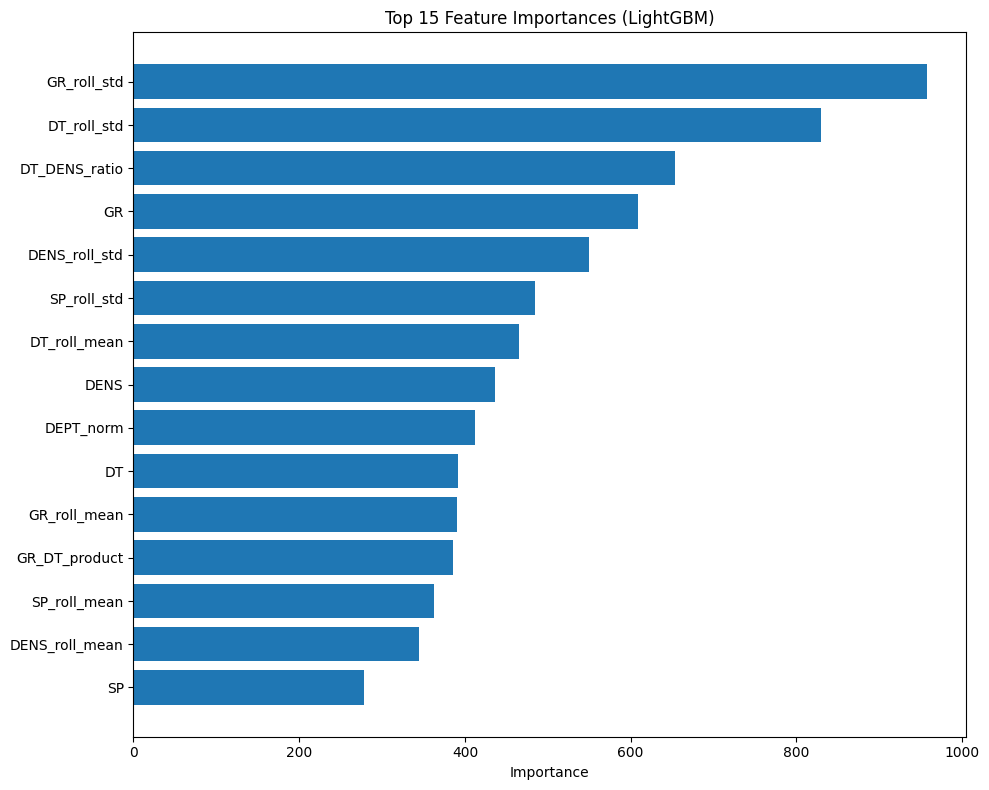

,feature,importance
17,GR_roll_std,957
18,DT_roll_std,830
6,DT_DENS_ratio,653
1,GR,609
19,DENS_roll_std,550
16,SP_roll_std,485
14,DT_roll_mean,465
3,DENS,436
20,DEPT_norm,412
2,DT,392


In [11]:
# Feature importance
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_importance

In [12]:
# Detailed classification report
print("LightGBM Classification Report:")
print(classification_report(y_test, lgb_pred))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     40547
           1       0.90      0.97      0.93     19909

    accuracy                           0.96     60456
   macro avg       0.94      0.96      0.95     60456
weighted avg       0.96      0.96      0.96     60456


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     40547
           1       0.92      0.95      0.94     19909

    accuracy                           0.96     60456
   macro avg       0.95      0.96      0.95     60456
weighted avg       0.96      0.96      0.96     60456



In [13]:
# Select best model
if lgb_f1 >= rf_f1:
    best_model = lgb_model
    best_model_name = "LightGBM"
else:
    best_model = rf_model
    best_model_name = "Random Forest"

print(f"Best model: {best_model_name}")

Best model: Random Forest


In [14]:
# Retrain on all data for final prediction
X_all = df[feature_cols]
y_all = df["LITHO"]

final_model = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1,
    n_estimators=300,
    class_weight='balanced',
)
final_model.fit(X_all, y_all)
print("Final model trained on all data")

Final model trained on all data


In [15]:
# Load validation data
validation_data = pd.read_csv(data_path / "Shestakovo_validation.csv")
print(f"Validation data shape: {validation_data.shape}")
print(f"Validation wells: {validation_data['Well'].nunique()}")

# Feature engineering for validation data (same as training)
val_df = validation_data.copy()

# Ratios and interactions
val_df['GR_DENS_ratio'] = val_df['GR'] / (val_df['DENS'] + 1e-6)
val_df['SP_GR_ratio'] = val_df['SP'] / (val_df['GR'] + 1e-6)
val_df['DT_DENS_ratio'] = val_df['DT'] / (val_df['DENS'] + 1e-6)
val_df['GR_DT_product'] = val_df['GR'] * val_df['DT']

# Normalized features within each well
for col in ['SP', 'GR', 'DT', 'DENS']:
    val_df[f'{col}_norm'] = val_df.groupby('Well')[col].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-6)
    )

# Rolling statistics per well
for col in ['SP', 'GR', 'DT', 'DENS']:
    val_df[f'{col}_roll_mean'] = val_df.groupby('Well')[col].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    val_df[f'{col}_roll_std'] = val_df.groupby('Well')[col].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).std()
    )

val_df = val_df.fillna(0)

# Depth-based features
val_df['DEPT_norm'] = val_df.groupby('Well')['DEPT'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
)

# Log transforms
val_df['GR_log'] = np.log1p(val_df['GR'].clip(lower=0))
val_df['DT_log'] = np.log1p(val_df['DT'].clip(lower=0))

print(f"Validation features shape: {val_df.shape}")
val_df.head()

Validation data shape: (111690, 6)
Validation wells: 324
Validation features shape: (111690, 25)


,DEPT,SP,GR,DT,DENS,Well,GR_DENS_ratio,SP_GR_ratio,DT_DENS_ratio,GR_DT_product,...,SP_roll_std,GR_roll_mean,GR_roll_std,DT_roll_mean,DT_roll_std,DENS_roll_mean,DENS_roll_std,DEPT_norm,GR_log,DT_log
0,2504.9,-46.297222,114.232483,297.346985,2.362223,201-901,48.358025,-0.405289,125.875868,33966.684368,...,0.226085,114.307941,0.106715,297.455902,0.154032,2.361670,0.000782,0.000000,4.746952,5.698257
1,2505.0,-46.616955,114.383400,297.564819,2.361117,201-901,48.444591,-0.407550,126.027080,34036.475752,...,0.245618,114.377358,0.141950,297.565104,0.218262,2.361155,0.001049,0.003584,4.748260,5.698987
2,2505.1,-46.780064,114.516190,297.783508,2.360126,201-901,48.521198,-0.408502,126.172663,34101.032696,...,0.081581,114.506864,0.119075,297.783803,0.219132,2.360185,0.000903,0.007168,4.749411,5.699719
3,2505.2,-46.702145,114.621002,298.003082,2.359313,201-901,48.582339,-0.407448,126.309197,34157.411952,...,0.039140,114.618879,0.101644,297.970642,0.173207,2.359464,0.000601,0.010753,4.750318,5.700454
4,2505.3,-46.747604,114.719444,298.125336,2.358954,201-901,48.631478,-0.407495,126.380282,34200.772843,...,0.175392,114.717255,0.095176,298.068451,0.061567,2.359198,0.000212,0.014337,4.751169,5.700863


In [16]:
# Make predictions on validation data
X_valid = val_df[feature_cols]
valid_predictions = final_model.predict(X_valid)

print(f"Predictions made: {len(valid_predictions)}")
print(f"Predicted class distribution:")
print(pd.Series(valid_predictions).value_counts())

Predictions made: 111690
Predicted class distribution:
0    72551
1    39139
Name: count, dtype: int64


In [17]:
# Set user name for submission
user_name = "Solution"

In [18]:
# Save predictions
submission = pd.Series(valid_predictions, name="prediction")
output_path = Path(".").resolve().parent / "pred.csv"
submission.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")
submission.head(20)

Predictions saved to /Users/mac/dev/oil-gas-labs/pred.csv


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: prediction, dtype: int64